In [25]:
import numpy as np
import numpy.linalg as la

def kinetic_energy(p, m):
    # Calculate the squared 2-norm of each momentum vector, then sum with mass consideration
    ke = np.sum(np.sum(p**2, axis=0) / (2 * m))  # axis=0 sums across rows for each column vector
    return ke

def potential_energy(q, f_c):
    energy = 0
    k = q.shape[1]  # Number of particles
    for i in range(k):
        for j in range(i + 1, k):
            r_ij = np.linalg.norm(q[:, i] - q[:, j])
            energy += f_c(r_ij)
    return energy

def v_t(q, t, e_t):
    # Assuming e(t) is a scalar or a vector function that properly broadcasts over q's dimensions
    return np.sum(e_t(t) * q)

# def f_c(x):
#     return 1/x # Straightforward to differentiate

# def df_c(x):
#     return -1/x**2

def f_c(x):
    return -1/x**2 # Straightforward to differentiate

def df_c(x):
    return 2/x**3

def e(t):
    return 0 # Consider conservative system initially

def H(p, q, m, f_c, e_t, t):
    return kinetic_energy(p, m) + potential_energy(q, f_c) + v_t(q, t, e_t)

def dH_dp_i(p, m, i):
    return p[:, i] / m[i]

def dH_dq_i(q, m, i):
    d, k = q.shape
    total = np.zeros(d)
    for j in range(k):
        if i == j:
            continue
        x = q[:, i] - q[:, j]
        norm_x = la.norm(x)
        total += x/norm_x * df_c(norm_x) * m[i] * m[j]
    return total

def dH_dp(p, m):
    d, k = p.shape
    diff_p = np.zeros_like(p)
    for i in range(k):
        diff_p[:, i] = dH_dp_i(p, m, i)
    return diff_p

def dH_dq(q, m):
    d, k = q.shape
    diff_q = np.zeros_like(q)
    for i in range(k):
        diff_q[:, i] = dH_dq_i(q, m, i)
    return diff_q
    
    

Leapfrog time!

In [26]:

def leapfrog_integration(q0, p0, m, dt, total_time):
    """
    Perform leapfrog integration.
    """
    steps = int(total_time / dt)
    q, p = q0.copy(), p0.copy()
    
    # Initialize arrays to store trajectories for plotting
    trajectories = np.zeros((q.shape[0], q.shape[1], steps + 1))
    trajectories[:, :, 0] = q
    
    momentums = np.zeros((p.shape[0], p.shape[1], steps + 1))
    momentums[:, :, 0] = p
    
    for step in range(steps):
        p_half = p - 0.5 * dt * dH_dq(q, m)
        q = q + dt * dH_dp(p_half, m)
        p = p_half - 0.5 * dt * dH_dq(q, m)
        
        # Store positions for plotting
        trajectories[:, :, step + 1] = q
        momentums[:, :, step + 1] = p
    
    return trajectories, momentums

In [58]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def plot_trajectories(trajectories):
    """
    Plot the trajectories of particles in a 2D system.
    """
    fig, ax = plt.subplots()
    k = trajectories.shape[1]  # Number of particles
    for i in range(k):
        ax.plot(trajectories[0, i, :], trajectories[1, i, :], label=f'Particle {i+1}')
    ax.legend()
    plt.show()


m = np.array([1, 1])  # Mass of orbiting body
q0 = 0.5*np.array([[-1, 0], [1, 0]]).T  # Initial position (right on the x-axis, at unit distance from origin)
v0 = np.array([[0, -1], [0, 1]]).T  # Initial velocity (perpendicular to the radius for circular orbit)

# Convert velocity to momentum
p0 = m * v0

# Time step and total simulation time
dt = 0.001
total_time = 2*np.pi  # One orbital period, simplified

trajectories, momentums = leapfrog_integration(q0, p0, m, dt, total_time)


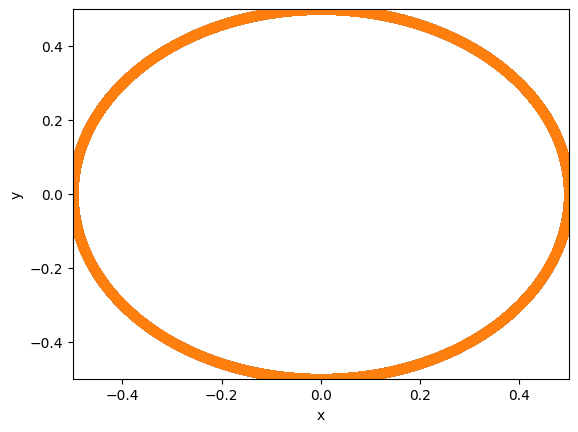

In [107]:


# Assuming trajectories is the output from leapfrog_integration
# plot_trajectories(trajectories)

# Make sure your notebook imports and trajectories setup are done before this

fig, ax = plt.subplots()
lines = []
for _ in range(trajectories.shape[1]):  # Create a line for each particle
    line, = ax.plot([], [], 'o-', lw=2)
    lines.append(line)

# Adjust limits if necessary
ax.set_xlim(np.min(trajectories[0, :, :]), np.max(trajectories[0, :, :]))
ax.set_ylim(np.min(trajectories[1, :, :]), np.max(trajectories[1, :, :]))
ax.set_xlabel('x')
ax.set_ylabel('y')

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    for j, line in enumerate(lines):
        line.set_data(trajectories[0, j, :i+1], trajectories[1, j, :i+1])
    return lines

ani = FuncAnimation(fig, animate, frames=trajectories.shape[2], init_func=init, blit=True, interval=20)

# Use IPython.display.HTML to display the animation as HTML5 video
HTML(ani.to_html5_video())



KeyboardInterrupt: 

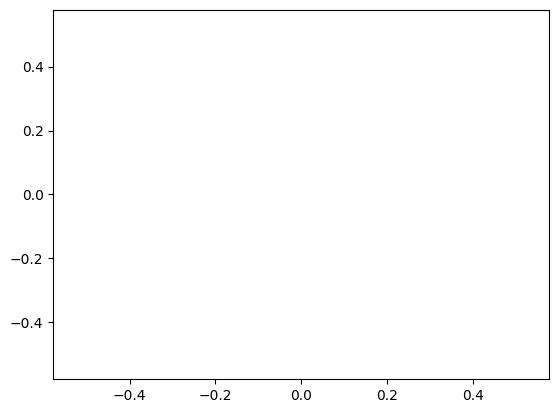

In [21]:

fig, ax = plt.subplots()
ax.set_xlim(np.min(trajectories[0, :, :]), np.max(trajectories[0, :, :]))
ax.set_ylim(np.min(trajectories[1, :, :]), np.max(trajectories[1, :, :]))
ax.set_xlabel('x')
ax.set_ylabel('y')

# Number of frames to show in the tail with fading effect
tail_length = 50  

def init():
    ax.clear()
    ax.set_xlim(np.min(trajectories[0, :, :]), np.max(trajectories[0, :, :]))
    ax.set_ylim(np.min(trajectories[1, :, :]), np.max(trajectories[1, :, :]))
    return ax,

def animate(i):
    ax.clear()
    ax.set_xlim(np.min(trajectories[0, :, :]), np.max(trajectories[0, :, :]))
    ax.set_ylim(np.min(trajectories[1, :, :]), np.max(trajectories[1, :, :]))
    for j in range(trajectories.shape[1]):
        # Determine the start index for the tail
        start_idx = max(i - tail_length, 0)
        # Compute fading alphas
        alphas = np.linspace(0.1, 1, i - start_idx + 1)
        for k, alpha in zip(range(start_idx, i + 1), alphas):
            ax.plot(trajectories[0, j, k:k+2], trajectories[1, j, k:k+2], 'o-', lw=2, alpha=alpha, color=f"C{j}")
    return ax,

ani = FuncAnimation(fig, animate, frames=trajectories.shape[2], init_func=init, blit=False, interval=20, repeat=True)

HTML(ani.to_html5_video())

In [112]:

import torch
from torch.utils.data import TensorDataset, DataLoader

d, k, steps = trajectories.shape 

trajectories_train = trajectories[:,:,:steps//2+1]
momentums_train = momentums[:,:,:steps//2+1]

d, k, steps = trajectories_train.shape 

# states = np.concatenate((trajectories_train, momentums_train), axis=1).reshape(steps, -1)
states = np.concatenate((trajectories_train.reshape(d*k, steps), momentums_train.reshape(d*k, steps)), axis=0).transpose()

prev = states[:-1]
next = states[1:]

# Convert to tensors
prev_tensor = torch.tensor(prev, dtype=torch.float32)
next_tensor = torch.tensor(next, dtype=torch.float32)

# Create dataset and dataloader
dataset = TensorDataset(prev_tensor, next_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [113]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 8),  # Adjust sizes according to your problem
            nn.Tanh(),
            nn.Linear(8, 8),
        )

    def forward(self, t, y):
        return self.net(y)

# Example usage
# Assuming X_tensor and Y_tensor are your input-target pairs, prepared as described earlier

ode = ODEFunc()

optimizer = torch.optim.Adam(ode.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # Mean Squared Error loss

epochs = 100  # Number of epochs to train for

for epoch in range(epochs):
    for batch_idx, (x_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        
        # Solve the ODE for each batch
        # odeint requires time tensor t, which in training can just be the start and end if constant step size is assumed
        t = torch.linspace(0, 1, 2)  # Example: Assuming a normalized time interval [0, 1]
        y_pred = odeint(ode, x_batch, t)[-1]  # Get the solution at t=1, which is the next state
        
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f"Epoch {epoch}: Loss = {loss.item()}")


Epoch 0: Loss = 0.0007738785352557898
Epoch 10: Loss = 7.503406322939554e-06
Epoch 20: Loss = 1.4168577990858466e-06
Epoch 30: Loss = 8.824637802717916e-07
Epoch 40: Loss = 3.0244203230722633e-07
Epoch 50: Loss = 1.6691062398876966e-07
Epoch 60: Loss = 1.5782535456310143e-07
Epoch 70: Loss = 6.788257422840616e-08
Epoch 80: Loss = 7.486814723733914e-08
Epoch 90: Loss = 8.38677252090747e-08


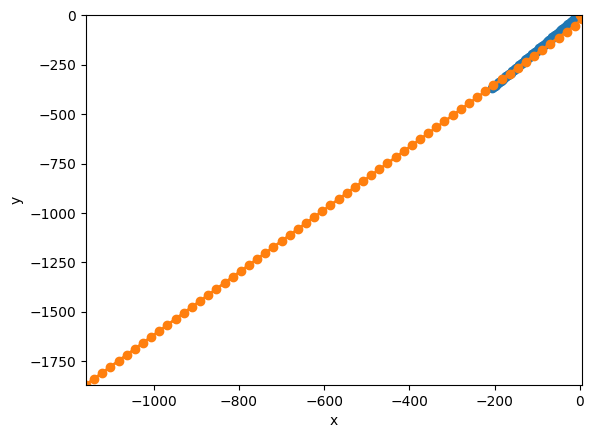

In [114]:
start = torch.tensor(states[0], dtype=torch.float32)

new_traj = odeint(ode, start, torch.linspace(0, steps*2-1, steps*2)).detach().numpy().reshape(steps*2, 2, 2, 2).transpose(1, 2, 3, 0)[0]


new_traj = new_traj[:,:,::100]

# Assuming trajectories is the output from leapfrog_integration
# plot_trajectories(trajectories)

# Make sure your notebook imports and trajectories setup are done before this

fig, ax = plt.subplots()
lines = []
for _ in range(new_traj.shape[1]):  # Create a line for each particle
    line, = ax.plot([], [], 'o-', lw=2)
    lines.append(line)

# Adjust limits if necessary
ax.set_xlim(np.min(new_traj[0, :, :]), np.max(new_traj[0, :, :]))
ax.set_ylim(np.min(new_traj[1, :, :]), np.max(new_traj[1, :, :]))
ax.set_xlabel('x')
ax.set_ylabel('y')

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    for j, line in enumerate(lines):
        line.set_data(new_traj[0, j, :i+1], new_traj[1, j, :i+1])
    return lines

ani = FuncAnimation(fig, animate, frames=new_traj.shape[2], init_func=init, blit=True, interval=20)

# Use IPython.display.HTML to display the animation as HTML5 video
HTML(ani.to_html5_video())



# torch.linspace(0, 1, 2)

In [74]:
test1 = trajectories[:,:,:3]
test2 = momentums[:,:,:3]
print('Trajectories')
print(test1)
print('Momentums')
print(test2)

print('Reshape')
print(test1.reshape(4, 3))

print('Concat')
flat = np.concatenate((test1.reshape(4, 3), test2.reshape(4, 3)), axis=0).transpose()
print(flat)
# states
# print(states)


Trajectories
[[[-0.5      -0.499999 -0.499996]
  [ 0.5       0.499999  0.499996]]

 [[ 0.       -0.001    -0.002   ]
  [ 0.        0.001     0.002   ]]]
Momentums
[[[ 0.          0.002       0.00399999]
  [ 0.         -0.002      -0.00399999]]

 [[-1.         -0.999998   -0.999992  ]
  [ 1.          0.999998    0.999992  ]]]
Reshape
[[-0.5      -0.499999 -0.499996]
 [ 0.5       0.499999  0.499996]
 [ 0.       -0.001    -0.002   ]
 [ 0.        0.001     0.002   ]]
Concat
[[-0.5         0.5         0.          0.          0.          0.
  -1.          1.        ]
 [-0.499999    0.499999   -0.001       0.001       0.002      -0.002
  -0.999998    0.999998  ]
 [-0.499996    0.499996   -0.002       0.002       0.00399999 -0.00399999
  -0.999992    0.999992  ]]


In [102]:
print(trajectories[:,:,:5])

new_traj = odeint(ode, start, torch.linspace(0, steps*2-1, steps*2)).detach().numpy().reshape(steps*2, 2, 2, 2).transpose(1, 2, 3, 0)[0]
print(new_traj[:,:,:5])

[[[-0.5        -0.499999   -0.499996   -0.499991   -0.499984  ]
  [ 0.5         0.499999    0.499996    0.499991    0.499984  ]]

 [[ 0.         -0.001      -0.002      -0.00299998 -0.00399996]
  [ 0.          0.001       0.002       0.00299998  0.00399996]]]
[[[-5.0000000e-01 -4.9970552e-01 -4.9947211e-01 -4.9929327e-01
   -4.9916503e-01]
  [ 5.0000000e-01  5.0005066e-01  5.0011939e-01  5.0021207e-01
    5.0033283e-01]]

 [[ 0.0000000e+00 -2.9604931e-04 -6.8515918e-04 -1.1489114e-03
   -1.6724103e-03]
  [ 0.0000000e+00  9.3136734e-04  1.8236844e-03  2.6876547e-03
    3.5326418e-03]]]
